In [ ]:
import datetime
import os

import pandas as pd

from src.config import DATA_DIR, MODEL_DIR, PARAM_DIR
from src.recommendation.NMF import train_nmf_model, model_type
from src.recommendation.all_evaluation import _results
from src.recommendation.evaluation import evaluate
from src.recommendation.mixture_functions import get_train
from src.util.data_io import get_dataset
from src.util.eval_measures import eval_lst
from src.util.io import save_pickle

train_model, model_type = train_nmf_model, model_type



In [3]:
model_type


'nmf_model'

In [4]:
data_dir = os.path.join(DATA_DIR, 'day')
results_dir = os.path.join(MODEL_DIR, 'tuning')


In [5]:
print(eval_lst)

[['recall', [5]], ['precision', [5]], ['nDCG', [5]]]


In [6]:
# subset Jan 20 - 22, 2015
datasets = ['120', '121', '122']


In [7]:
k_vals = [5, 10, 50, 100, 500]


In [8]:
overwrite = False
save_multinomials = True


def hours_minutes_seconds(td):
    return '{:02}:{:02}:{:02}'.format(td.seconds // 3600, (td.seconds // 60) % 60, td.seconds % 60)


def eval_dataset(dataset, k_vals):
    result_dic = {}

    for n_components in k_vals:
        print(n_components)
        train, val, test = get_dataset(dataset, data_dir)
        start_time = datetime.datetime.now()
        all_multinomials = train_model(train, val, test, results_dir,
                                       dataset, overwrite=False, save_multinomials=True,
                                       n_components=n_components, is_tune=True)
        end_time = datetime.datetime.now()
        time_used = hours_minutes_seconds(end_time - start_time)
        print('time_used', time_used)
        dataset, eval_result = _results(dataset, eval_lst, val, all_multinomials)
        eval_result.append(['time_used', time_used])
        result_dic.update({n_components: eval_result})

    df = pd.DataFrame(result_dic).T
    df.columns = [item for sublist in list(result_dic.values())[0] for item in sublist[:1]]
    for col in df.columns:
        df[col] = df[col].apply(lambda s: s[1])
    return df


In [9]:
dfs = dict()
for dataset in datasets:
    dataset = str(dataset)
    df = eval_dataset(dataset, k_vals)
    dfs.update({dataset: df})


5
2019-10-22 16:34:35,372 INFO --> Loading data for 120
time_used 00:00:08
recall@5: 0.05916
precision@5: 0.06474
nDCG@5: 0.09130
10
2019-10-22 16:35:36,010 INFO --> Loading data for 120
time_used 00:00:08
recall@5: 0.06610
precision@5: 0.07424
nDCG@5: 0.10747
50
2019-10-22 16:36:33,876 INFO --> Loading data for 120
time_used 00:00:37
recall@5: 0.09622
precision@5: 0.09913
nDCG@5: 0.14940
100
2019-10-22 16:38:00,502 INFO --> Loading data for 120
time_used 00:01:42
recall@5: 0.11727
precision@5: 0.11702
nDCG@5: 0.17317
500
2019-10-22 16:40:32,849 INFO --> Loading data for 120
time_used 00:41:49
recall@5: 0.21183
precision@5: 0.19793
nDCG@5: 0.27853
5
2019-10-22 17:23:18,311 INFO --> Loading data for 121
time_used 00:00:09
recall@5: 0.05854
precision@5: 0.06625
nDCG@5: 0.09353
10
2019-10-22 17:24:31,048 INFO --> Loading data for 121
time_used 00:00:10
recall@5: 0.06850
precision@5: 0.07855
nDCG@5: 0.11152
50
2019-10-22 17:25:43,349 INFO --> Loading data for 121
time_used 00:00:41
recall@

In [10]:
df

,recall@5,precision@5,nDCG@5,time_used
5,0.061546,0.070398,0.098419,00:00:09
10,0.065170,0.074520,0.108555,00:00:13
50,0.101930,0.111891,0.163253,00:00:53
100,0.124900,0.131662,0.190629,00:02:10
500,0.217281,0.209468,0.290750,00:43:48


In [11]:
eval_measure = df.columns.tolist()
eval_measure


['recall@5', 'precision@5', 'nDCG@5', 'time_used']

In [12]:
def plot_metric(col):
    try:
        df_plot = pd.DataFrame({c: df[col] for c, df in dfs.items()})
        df_plot.plot(logx=True, xticks=k_vals, title=col.upper() + ' for different k')
    except:
        # time is not numeric value
        return df_plot


In [13]:
for k, df in dfs.items():
    print(k)
    print(df['nDCG@5'].idxmax())


120
500
121
500
122
500


          120       121       122
5    00:00:08  00:00:09  00:00:09
10   00:00:08  00:00:10  00:00:13
50   00:00:37  00:00:41  00:00:53
100  00:01:42  00:02:11  00:02:10
500  00:41:49  00:41:36  00:43:48


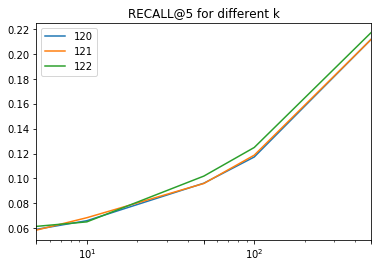

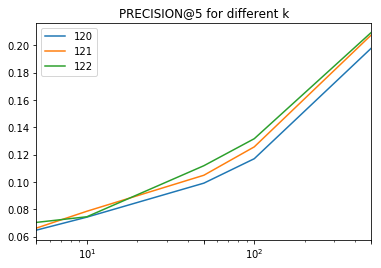

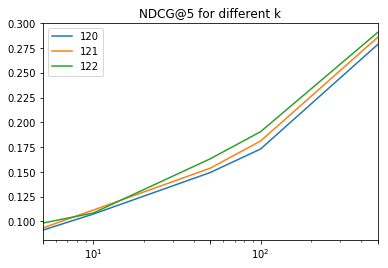

In [14]:
for col in eval_measure:
    df_time = plot_metric(col)
print(df_time)


In [16]:
# n_component=500 taking too much time (over half an hour), use 100 instead
save_pickle(os.path.join(PARAM_DIR, model_type), 100, False)
